In this notebook,
we study a training scenario in which the loss plateaus for a long time,
before suddenly going down again.

This is related to https://arxiv.org/abs/2201.02177.

### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import matplotlib.pyplot as plt
import torch as t
import torch.nn.functional as F
from torch import optim
from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast


### Load tokenizer + construct example

In [61]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
tokenizer.vocab_size

28996

In [62]:
text = "The cow likes to eat grass."
mask = [False, False, False, False, True, False, True, False, False]
assert len(mask) == len(tokenizer(text).input_ids)

In [63]:
batch_x_full = tokenizer(text, return_tensors="pt").input_ids.cuda()

batch_mask = t.tensor([mask], dtype=t.bool).cuda()
batch_y = t.masked_select(batch_x_full, mask=batch_mask).cuda()

batch_x = batch_x_full.clone()
batch_x[batch_mask] = tokenizer.mask_token_id

print(tokenizer.batch_decode(batch_x))
print(tokenizer.decode(batch_y))

['[CLS] The cow likes [MASK] eat [MASK]. [SEP]']
to grass


### Experiments

In [72]:
from days.w2d1 import bert_sol
from days.w4d1 import bert_fixed, bert_grok

t.manual_seed(42)

# Bert = bert_sol.Bert
Bert = bert_grok.Bert
#Bert = bert_fixed.Bert

tiny_bert = Bert(
    vocab_size=tokenizer.vocab_size,
    hidden_size=256,
    max_position_embeddings=512,
    type_vocab_size=2,
    dropout=0,
    intermediate_size=1024,
    num_heads=4,
    num_layers=1,
).cuda()
tiny_bert.train()

optimizer = optim.Adam(tiny_bert.parameters(), lr=1e-3)

losses = []
for i in range(1000):

    logits = tiny_bert(batch_x)
    pred_logits_flat = t.masked_select(logits, batch_mask.unsqueeze(-1))
    pred_logits = pred_logits_flat.reshape((-1, logits.shape[-1]))
    loss = F.cross_entropy(input=pred_logits, target=batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if i % 100 == 0:
        print(i, loss.item())


0 11.052814483642578
100 3.0397906812140718e-05
200 2.6106492441613227e-05
300 2.2291887944447808e-05
400 1.9132909073960036e-05
500 1.6629557649139315e-05
600 1.4662635294371285e-05
700 1.2934124242747203e-05
800 1.1444026313256472e-05
900 1.0251946150674485e-05


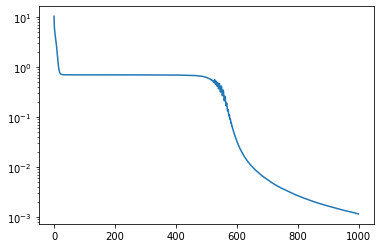

In [53]:
plt.plot(losses)
plt.yscale("log")